# import data

In [1]:
import platform
import pandas as pd
from datetime import datetime, timedelta, time
ohlcv_data = pd.read_pickle('/Users/bokie/code/python/CMS/可转债套利/cms/stock_data_min_new.pkl')
print(ohlcv_data.keys())
for k,v in ohlcv_data.items():
    print(k,' data length: ',len(v))
print('数据起始日期',v.index[0])
print('数据结束日期',v.index[-1])
print('113642.SH数据起始日期',ohlcv_data['113642.SH'].index[0])
print('113642.SH数据结束日期',ohlcv_data['113642.SH'].index[-1])

dict_keys(['123046.SZ', '300587.SZ', '113642.SH', '603185.SH', '110061.SH', '600674.SH', '128081.SZ', '002203.SZ'])
123046.SZ  data length:  31460
300587.SZ  data length:  31460
113642.SH  data length:  13552
603185.SH  data length:  31460
110061.SH  data length:  31460
600674.SH  data length:  31460
128081.SZ  data length:  31460
002203.SZ  data length:  31460
数据起始日期 2021-12-13 09:30:00
数据结束日期 2022-06-28 15:00:00
113642.SH数据起始日期 2022-04-06 09:30:00
113642.SH数据结束日期 2022-06-28 15:00:00


# bond-stock pair

In [2]:
# cbond_pair = ['128081.SZ','002203.SZ']
# part = 1
# convert_price = 9.69
# stock_volume = 100/convert_price #整个回测期间不变


# cbond_pair = ['123046.SZ','300587.SZ']
# part = 1 
# convert_price = 6.73
# stock_volume = 100/convert_price  # 2021-12-13至2022-03-23
# part = 2
# convert_price = 6.74
# stock_volume = 100/convert_price  # 2022-03-24至2022-06-28


# cbond_pair = ['110061.SH','600674.SH']
# part = 1
# convert_price = 9.2
# stock_volume = 100/convert_price #整个回测期间不变


cbond_pair = ['113642.SH','603185.SH']
# part = 1
# convert_price = 145.66
# stock_volume = 100/convert_price  # 2022-04-06至2022-06-02
part = 2
convert_price = 102.61
stock_volume = 100/convert_price  # 2022-06-03至2022-06-28


In [3]:
cbond_pair_price = pd.DataFrame([])
cbond_pair_price = pd.concat([ohlcv_data[cbond_pair[0]]['close'],ohlcv_data[cbond_pair[1]]['close']],axis=1)
cbond_pair_price.columns = cbond_pair
cbond_pair_price = cbond_pair_price.dropna()
if cbond_pair[0] == '128081.SZ' or cbond_pair[0] == '110061.SH':
    cbond_pair_price = cbond_pair_price.loc['2021-12-13 15:00:00':]
elif cbond_pair[0] == '123046.SZ' and part == 1:
    cbond_pair_price = cbond_pair_price.loc['2021-12-13 15:00:00':'2022-03-23 15:00:00']
elif cbond_pair[0] == '123046.SZ' and part == 2:
    cbond_pair_price = cbond_pair_price.loc['2022-03-25 15:00:00':]
elif cbond_pair[0] == '113642.SH' and part == 1:
    cbond_pair_price = cbond_pair_price.loc['2022-04-07 15:00:00':'2022-06-02 15:00:00']
elif cbond_pair[0] == '113642.SH' and part == 2:
    cbond_pair_price = cbond_pair_price.loc['2022-06-03 15:00:00':]


# signal calculate

In [4]:
cbond_return = pd.DataFrame([])

cbond_preclose = cbond_pair_price.iloc[0,0] # 初始时刻的bond前收盘价
stock_preclose = cbond_pair_price.iloc[0,1] # 初始时刻的stock前收盘价

for index,row in cbond_pair_price.iterrows():
    
    cbond_return.loc[index,cbond_pair[0]] = row[cbond_pair[0]]/cbond_preclose - 1 # 算日内的return
    cbond_return.loc[index,cbond_pair[1]] = row[cbond_pair[1]]/stock_preclose - 1

    if index.time()==time(15,0,0):  #算完日内return，迭代到今日价格的最后一个time bar的时候，将其设为前收盘价
        cbond_preclose = row[cbond_pair[0]]    # 日内return指标用 现价/昨日收盘价 计算
        stock_preclose = row[cbond_pair[1]]
        
# 检查df是否有空值
cbond_return.isnull().sum(axis=0)  # 按列统计
cbond_return.isnull().sum(axis=1) # 按行统计
cbond_return.isnull().sum(axis=1).sum() # 统计整张表

0

In [5]:
pd.set_option('display.max_rows', None)
cbond_return['diff'] = cbond_return[cbond_pair[0]] - cbond_return[cbond_pair[1]]

In [6]:
open_threshold = 0.01  # 0.005 ~ 0.01 ~ 0.015 间隔是0.001
# open_threshold = 0.008
close_threshold = 0.001 #  0 ~ 0.001 ~ 0.002 ~ 0.003
open_flag = 0
cbond_position = pd.DataFrame([])
cbond_position.index = cbond_return.index
for index,row in cbond_return.iterrows():
    if abs(row['diff']) > open_threshold and open_flag==0:  # diff大于开仓阈值，并且无仓位就开仓
        open_flag = 1
        if row['diff'] > 0:  # diff 绝对值大于0.01并且diff是正数，说明bond偏高了，做空之，stock则反向开仓
            cbond_position.loc[index,cbond_pair[0]] = -1*open_flag  #short bond, long stock
            cbond_position.loc[index,cbond_pair[1]] = open_flag
        else:                # diff 绝对值大于0.01并且diff是负数，说明bond偏低了，做多之，stock则反向开仓
            cbond_position.loc[index,cbond_pair[0]] = open_flag     #long bond, short stock
            cbond_position.loc[index,cbond_pair[1]] = -1*open_flag
    
    elif abs(row['diff']) < close_threshold and open_flag==1: # diff小于平仓阈值，并且有仓位就平仓
    # elif abs(row['diff']) < close_threshold and open_flag==1: # diff小于平仓阈值，并且有仓位就平仓
        open_flag = 0   # diff 绝对值小于阈值时，认为股债的偏移效应减弱，走势收敛，此时平仓
        cbond_position.loc[index,cbond_pair[0]] = open_flag
        cbond_position.loc[index,cbond_pair[1]] = open_flag
    
    else: # diff介于开仓阈值和平仓阈值之间，并且diff大于0，short bond long stock,小于0则short stock long bond
        if row['diff'] > 0:
            cbond_position.loc[index,cbond_pair[0]] = -1*open_flag
            cbond_position.loc[index,cbond_pair[1]] = open_flag
        else:
            cbond_position.loc[index,cbond_pair[0]] = open_flag
            cbond_position.loc[index,cbond_pair[1]] = -1*open_flag

    if index.time()==time(15,0,0): # 每日收盘时必须平仓（时间止损信号）
        open_flag = 0 
        cbond_position.loc[index,cbond_pair[0]] = open_flag
        cbond_position.loc[index,cbond_pair[1]] = open_flag
# cbond_position.to_csv('cbond_position.csv')

In [7]:
open_threshold = 0.01  # 0.005 ~ 0.01 ~ 0.015 间隔是0.001
# open_threshold = 0.008
close_threshold = 0.001 #  0 ~ 0.001 ~ 0.002 ~ 0.003
pos_open_flag = 0
neg_open_flag = 0
cbond_position = pd.DataFrame([])
cbond_position.index = cbond_return.index
for index,row in cbond_return.iterrows():

    if row['diff'] >= open_threshold and pos_open_flag==0 and neg_open_flag==0:
        #diff落在A区间，且无仓位，正开
        pos_open_flag = 1
        neg_open_flag = 0
        cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
        cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
    elif row['diff'] >= open_threshold and pos_open_flag==0 and neg_open_flag==1:
        #diff落在A区间，且有负仓，平仓再正开
        pos_open_flag=1
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
        cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
    elif row['diff'] >= open_threshold and pos_open_flag==1 and neg_open_flag==0:
        #diff落在A区间，且有正仓，keep
        pos_open_flag=1
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
        cbond_position.loc[index,cbond_pair[1]] = pos_open_flag

    if row['diff'] > close_threshold and row['diff'] < open_threshold and pos_open_flag==1 and neg_open_flag==0:
        #diff 落在B区间，且有正仓，keep
        pos_open_flag=1
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
        cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
    elif row['diff'] > close_threshold and row['diff'] < open_threshold and pos_open_flag==0 and neg_open_flag==1:
        #diff 落在B区间，且有负仓，平仓
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
        cbond_position.loc[index,cbond_pair[1]] = neg_open_flag
    elif row['diff'] > close_threshold and row['diff'] < open_threshold and pos_open_flag==0 and neg_open_flag==0:
        #diff 落在B区间，且无仓，keep
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
        cbond_position.loc[index,cbond_pair[1]] = neg_open_flag
    
    if row['diff'] >= -1*close_threshold and row['diff'] <= close_threshold and pos_open_flag==1 and neg_open_flag==0:
        #diff 落在C区间，且有正仓，平仓
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = pos_open_flag
        cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
    elif row['diff'] >= -1*close_threshold and row['diff'] <= close_threshold and pos_open_flag==0 and neg_open_flag==1:
        #diff 落在C区间，且有负仓，平仓
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
        cbond_position.loc[index,cbond_pair[1]] = neg_open_flag
    elif row['diff'] >= -1*close_threshold and row['diff'] <= close_threshold and pos_open_flag==0 and neg_open_flag==0:
        #diff 落在C区间，且无仓位，keep
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
        cbond_position.loc[index,cbond_pair[1]] = neg_open_flag
    
    if row['diff'] > -1*open_threshold and row['diff'] < -1*close_threshold and pos_open_flag==0 and neg_open_flag==1:
        #diff 落在D区间，且有负仓，keep
        pos_open_flag=0
        neg_open_flag=1
        cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
        cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag

    elif row['diff'] > -1*open_threshold and row['diff'] < -1*close_threshold and pos_open_flag==1 and neg_open_flag==0:
        #diff 落在D区间，且有正仓，平仓
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = pos_open_flag
        cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
    elif row['diff'] > -1*open_threshold and row['diff'] < -1*close_threshold and pos_open_flag==0 and neg_open_flag==0:
        #diff 落在D区间，且无仓位，keep
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = pos_open_flag
        cbond_position.loc[index,cbond_pair[1]] = pos_open_flag

    if row['diff'] <= -1*open_threshold and pos_open_flag==0 and neg_open_flag==0:
        #diff 落在E区间，且无仓位，反开
        pos_open_flag=0
        neg_open_flag=1
        cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
        cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag
    elif row['diff'] <= -1*open_threshold and pos_open_flag==1 and neg_open_flag==0:
        #diff 落在E区间，且有正仓，平仓反开
        pos_open_flag=0
        neg_open_flag=1
        cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
        cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag
    elif row['diff'] <= -1*open_threshold and pos_open_flag==0 and neg_open_flag==1:
        #diff 落在E区间，且有负仓，keep
        pos_open_flag=0
        neg_open_flag=1
        cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
        cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag

    if index.time()==time(15,0,0): # 每日收盘时必须平仓（时间止损信号）
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = pos_open_flag
        cbond_position.loc[index,cbond_pair[1]] = pos_open_flag

In [8]:
df_signal = pd.concat([cbond_pair_price,cbond_return,cbond_position],axis=1)
df_signal.columns = ['bond_price','stock_price','bond_rtn','stock_rtn','diff','bond_pos','stock_pos']
print('open threshold',open_threshold,'close threshold',close_threshold)
df_signal.to_csv('tmp_signal.csv')
# df_signal

open threshold 0.01 close threshold 0.001


# backtest

In [9]:
# 用来记录交易流水的表格,一边遍历df_signal，一边填入内容到流水表格里

import numpy as np
cols = ['balance','signal','bond price','stock price','bond hold','stock hold','commission','tax','reverse open']
df_trade = pd.DataFrame(
    data = [[0,np.nan,np.nan,np.nan,0,0,0,0,np.nan]],
    columns=cols
    ) 

balance_last = 0 # 现金账户初始余额

bond_hold = 0 # 债券持有数量
stock_hold = 0 # 股票持有数量

commission_rate = 2/10000 # 佣金买卖万二
tax_rate = 1/1000 #



for i in range(len(df_signal)-1):
    if df_signal.values[i][-1] != df_signal.values[i+1][-1]:
        index = df_signal.index[i+1]

    # df_signal的columns
    # ['bond_price','stock_price','bond_rtn','stock_rtn','diff','bond_pos','stock_pos']
        signal = str(int(df_signal.values[i+1][-2]))+str(int(df_signal.values[i+1][-1]))
        
        bond_price = df_signal.values[i+1][0] 

        stock_price = df_signal.values[i+1][1]

        commission = (bond_price + stock_price * stock_volume) * commission_rate

        reverse_open = False #表明这笔交易，是否包含平仓后再反向开仓的操作

        if signal == '00' and stock_hold == stock_volume: #有股票持仓并且需要卖出平仓时，有印花税
            tax = stock_price * tax_rate * stock_volume
        else:
            tax = 0

        if signal == '00':
            balance_last += bond_hold*bond_price
            balance_last += stock_hold*stock_price
            
            bond_hold = 0
            stock_hold = 0
            

        if signal == '1-1':
            '''
            加一个检测之前持仓的模块,如果之前因为-11的信号有持仓,需要先平掉(即买债卖股票),同时再反向开仓
            '''
            reverse_flag = False
            if bond_hold == -1 and stock_hold == 1*stock_volume:
                bond_hold = 0
                stock_hold = 0
                balance_last -= bond_price 
                balance_last += stock_price * stock_volume
                commission *= 2 # 因为平掉之后再反向开仓，手续费double
                tax = stock_price * tax_rate * stock_volume # 卖股票要收印花税
                reverse_flag = True
                reverse_open = True

            bond_hold += 1
            stock_hold += (-1 * stock_volume)
            # stock_hold += stock_volume
            balance_last -= bond_price
            balance_last += stock_price * stock_volume
            
            if reverse_flag:
                tax *= 2 #平仓然后反向开仓的时候 已经计算过tax了，直接double
            else:
                tax = stock_price * tax_rate * stock_volume # 卖股票要收印花税

        if signal == '-11':
            '''
            加一个检测之前持仓的模块,如果之前因为1-1的信号有持仓,需要先平掉(卖债买股票),同时再反向开仓
            '''
            if bond_hold == 1 and stock_hold == -1*stock_volume:
                bond_hold = 0
                stock_hold = 0
                balance_last += bond_price
                balance_last -= stock_price * stock_volume
                commission *= 2 # 因为平掉之后再反向开仓，手续费double
                                # 买股票无印花税
                reverse_open = True
            bond_hold += -1
            stock_hold += (1 * stock_volume)
            # stock_hold += stock_volume
            balance_last += bond_price
            balance_last -= stock_price * stock_volume
        

        balance = balance_last

        line = [balance,signal,bond_price,stock_price,bond_hold,stock_hold,commission,tax,reverse_open]
        # df_trade.loc[index,['balance','asset','signal','bond price','stock price','commission','tax']] = line
        # df_trade.loc[index,cols] = [0,0,np.nan,np.nan,np.nan,0,0,0,0]
        df_trade.loc[index,cols] = line

       
# df_trade

In [10]:
df_trade['net value'] = df_trade['balance'] + \
                        df_trade['bond price']*df_trade['bond hold'] + \
                        df_trade['stock price']*df_trade['stock hold'] - \
                        df_trade['commission'] - \
                        df_trade['tax']
# df_trade

In [11]:
#把交易序列单个时间节点的扩展到整个序列
# assert False
df_nv = df_trade[['net value']].iloc[1:]
df_nv['time'] = df_nv.index
df_tmp = df_signal[['diff']]
df_tmp['time'] = df_tmp.index
#  merge之后再前向往后fillna
df_nv_full =  pd.merge(df_nv,df_tmp,how='outer').sort_values(by='time').fillna(method='ffill').fillna(0)
df_nv_full.index = df_tmp.index
df_nv_full = df_nv_full[['net value']]


/var/folders/4y/tm0f5s2n00s3g71c6qrvd0bh0000gn/T/ipykernel_94063/788458400.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['time'] = df_tmp.index


<AxesSubplot:>

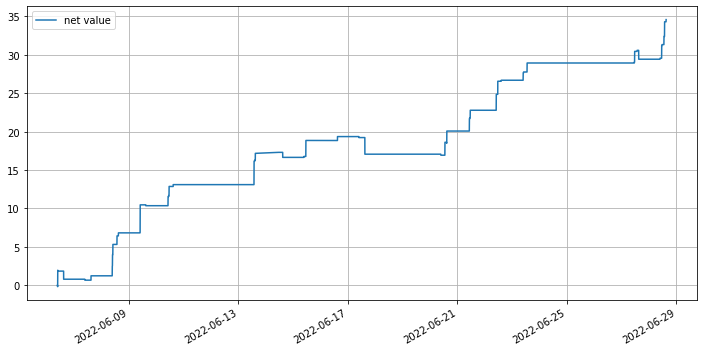

In [12]:
df_nv_full.plot(figsize=(12,6),grid=True,)

# statistic & analysis

In [13]:
df_trade_2 = df_trade.copy(deep=True)
rounds = [] #只包含单个来回，每2条交易记录组成一个来回的组
reverse_rounds = [] # 包含多个来回，信号之间包含平仓同时反向开仓的组
for i in range(len(df_trade)-1,0,-1):
# for i in range(len(df_trade)-1,-1,-1):
    if df_trade_2.iloc[i-1,:]['signal'] == '00':
        round = df_trade_2.iloc[i:,:]
        if len(round)>2:
            reverse_rounds.append(round)
        else:
            rounds.append(round)
        df_trade_2 = df_trade_2.iloc[:i]

In [14]:
num_round = len(rounds)
for i in reverse_rounds:
    num_round += len(i)-1
print('single round:',num_round)
print('reverse rounds: ',len(reverse_rounds))

single round: 32
reverse rounds:  0


In [15]:
return_in_rounds = []
win = 0
lose = 0
win_profit = 0
lose_profit = 0
for i in rounds:
    
    tmp_profit = (i['net value'] - i['net value'].shift(1)).values[-1]
    single_round_cost = (i['bond price'].sum() + (i['stock price']*stock_volume).sum())/4
    
    return_in_round = tmp_profit/single_round_cost
    return_in_rounds.append(return_in_round)
    
    
    if tmp_profit>0:
        win += 1
        win_profit += tmp_profit
    else:
        lose += 1
        lose_profit += tmp_profit
print('win: ',win)
print('lose: ',lose)
print('win profit: ',win_profit)
print('lose profit: ',lose_profit)
print(len(return_in_rounds))

win:  27
lose:  5
win profit:  36.599211434752874
lose profit:  -5.131994547120177
32


In [16]:
''' 
先把连续反向开仓的信号拆开
e.g.  1-1 -11 00 ---> 1-1 00 -11 00
'''

reverse_rounds_reconstruct = []
for reverse_round in reverse_rounds:
    reverse_rounds0_reconstruct = []
    for i in range(0,len(reverse_round)-1): #4-2

        # tmp_cols = reverse_rounds[0].columns
        # tmp_index = reverse_rounds[0].iloc[i,:].reset_index()
        m = reverse_round.iloc[i,:].tolist()
        n = reverse_round.iloc[i+1,:].tolist()
        # reverse_rounds0_reconstruct.append(m)
        tmp_balance = m[0] + n[2]*m[4] + n[3]*m[5] 
        tmp_commission = n[6]/2
        tmp_tax = n[7]/2
        tmp_nv =  tmp_balance - tmp_commission - tmp_tax
        
        insert_line  = [tmp_balance,'00',np.nan,np.nan,0,0,tmp_commission,tmp_tax,'-',tmp_nv]
        reverse_rounds0_reconstruct.append(m)
        reverse_rounds0_reconstruct.append(insert_line)
    # reverse_rounds0_reconstruct.append(n)    
    tmp_cols = reverse_round.columns
    reverse_rounds0_reconstruct[-1] = reverse_round.iloc[-1,:].tolist()
    tmp_round = pd.DataFrame(reverse_rounds0_reconstruct[:],columns=tmp_cols)
    tmp_round
    for index,row in tmp_round.iterrows():
        if row['reverse open'] == True:
            tmp_round.loc[index,['commission','tax']] = tmp_round.loc[index,['commission','tax']]/2
    tmp_round = tmp_round.fillna(method = 'bfill')
    reverse_rounds_reconstruct.append(tmp_round)
    tmp_round['new nv'] = tmp_round['balance'] + tmp_round['bond price']*tmp_round['bond hold'] + tmp_round['stock price']*tmp_round['stock hold'] - tmp_round['commission'] - tmp_round['tax']




In [17]:
reverse_rounds_detail = []
for reverse_round in reverse_rounds_reconstruct:
    print(len(reverse_round))
    for i in range(0,len(reverse_round)-1,2):
        df_tmp = reverse_round.iloc[i:i+2,:]
        reverse_rounds_detail.append(df_tmp)
print(len(reverse_rounds_detail))

0


In [18]:
# return_in_rounds = []
# win = 0
# lose = 0
# win_profit = 0
# lose_profit = 0
for i in reverse_rounds_detail:
    
    tmp_profit = (i['new nv'] - i['new nv'].shift(1)).values[-1]
    single_round_cost = (i['bond price'].sum() + (i['stock price']*stock_volume).sum())/4
    
    return_in_round = tmp_profit/single_round_cost
    return_in_rounds.append(return_in_round)
    
    
    if tmp_profit>0:
        win += 1
        win_profit += tmp_profit
    else:
        lose += 1
        lose_profit += tmp_profit
print('win: ',win)
print('lose: ',lose)
print('win profit: ',win_profit)
print('lose profit: ',lose_profit)
print(len(return_in_rounds))

win:  27
lose:  5
win profit:  36.599211434752874
lose profit:  -5.131994547120177
32


# final performance

In [19]:
win_rate = win/(win+lose)
win_profit_avg = win_profit/win
lose_profit_avg = lose_profit/lose
profit_ratio = win_profit_avg/abs(lose_profit_avg)

total_round = win + lose 

trade_days = len(df_nv_full.resample('D').last().dropna()) -1 
round_per_day = total_round/trade_days
return_per_round = sum(return_in_rounds)/len(return_in_rounds)
print('$'*50)
print('pair code:',cbond_pair)
print('convert price: ',convert_price)
print('first trade time',df_trade.index[1])
print('last trade time',df_trade.index[-1])
print('$'*50)
print('win: ',win)
print('lose: ',lose)
print('win profit: ',win_profit)
print('lose profit: ',lose_profit)
print('sum of win&lose profit: ',win_profit+lose_profit)
print('final net value:',df_trade['net value'].values[-1])
print('win rate: ', win_rate)
print('profit ratio: ',profit_ratio)
print('trade days: ',trade_days)
print('total round: ',total_round)
print('avg round in a day: ',round_per_day)
print('return_per_round: ',return_per_round)
print('@'*80)


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
pair code: ['113642.SH', '603185.SH']
convert price:  102.61
first trade time 2022-06-06 09:41:00
last trade time 2022-06-28 15:00:00
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
win:  27
lose:  5
win profit:  36.599211434752874
lose profit:  -5.131994547120177
sum of win&lose profit:  31.467216887632695
final net value: 34.56309177877399
win rate:  0.84375
profit ratio:  1.3206623048693087
trade days:  16
total round:  32
avg round in a day:  2.0
return_per_round:  0.007185507757367106
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


In [20]:
df_res = pd.DataFrame(data = [[np.nan]*14],
    columns=['cbond pair','convert price','win','lose','win profit','lose profit',
    'sum of win&lose profit','final net value','win rate',
    'profit ratio','trade days','total round','avg round in a day','return per round'])

tmp_idx = str(df_trade.index[1]) + ' -> ' + str(df_trade.index[-1])
tmp_line = [cbond_pair,convert_price,win,lose,win_profit,lose_profit,
            win_profit+lose_profit,df_trade['net value'].values[-1],win_rate,
            profit_ratio,trade_days,total_round,round_per_day,return_per_round]

df_res.loc[tmp_idx,df_res.columns] = tmp_line
df_res = df_res.dropna()
df_res

/Users/bokie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,cbond pair,convert price,win,lose,win profit,lose profit,sum of win&lose profit,final net value,win rate,profit ratio,trade days,total round,avg round in a day,return per round
2022-06-06 09:41:00 -> 2022-06-28 15:00:00,"[113642.SH, 603185.SH]",102.61,27.0,5.0,36.599211,-5.131995,31.467217,34.563092,0.84375,1.320662,16.0,32.0,2.0,0.007186


# output to excel

In [21]:
df_performance = pd.read_excel('performance_2.xlsx',index_col=0)
df_performance = df_performance.append(df_res)
df_performance.to_excel('performance_2.xlsx')